In [1]:
import pickle
import numpy as np
import pandas as pd
import torch
from torch import nn
import random
from torch.utils.data import TensorDataset, DataLoader
from tqdm.notebook import tqdm
import os
import matplotlib.pyplot as plt
import scipy
import yfinance as yf
from empyrical import sharpe_ratio
from sklearn.preprocessing import LabelEncoder
from src.features import DeepMomentumFeatures, MACDFeatures, DatetimeFeatures, DefaultFeatureCreator
from src.utils import MultivariateTrainValTestSplitter
from src.models import *

In [2]:
torch.__version__

'2.0.0'

In [3]:
with open('sectors_dict.pickle', 'rb') as f:
    sectors = pickle.load(f)

In [4]:
SEED = 42
N_ASSETS_PER_SECTOR = 5
LENGTH_THRESHOLD = 3000
DATASET_DIRNAME = 'yf_data'
USE_ADJUSTED_CLOSE = True

In [5]:
np.random.seed(SEED)
all_dfs = []
all_used_assets = []
for current_sector in sectors.keys():
    dfs = []
    assets = []
    for asset in sectors[current_sector]:
        df = pd.read_csv(os.path.join(DATASET_DIRNAME, f'{current_sector}', f'{asset}.csv'))
        # use only stocks with long enough history
        if len(df) > LENGTH_THRESHOLD:
            df['Date'] = pd.to_datetime(df['Date'])
            
            close_col = 'Adj Close' if USE_ADJUSTED_CLOSE else 'Close'
            
            cols = ['Date', 'Open', 'High', 'Low', close_col, 'Volume']
            
            df = df[cols]
            
            df.columns = ['Date'] + ['{}_{}'.format(asset, name) for name in \
                                     ['open', 'high', 'low', 'close', 'volume']]
            dfs.append(df)
            assets.append(asset)

    df = dfs[0]
    for i in range(1, len(dfs)):
        df = pd.merge(df, dfs[i], left_on='Date', right_on='Date', how='inner')

    used_assets = np.random.choice(assets, N_ASSETS_PER_SECTOR, replace=False)
    df = df[['Date'] + [name for name in df.columns[1:] if name.split('_')[0] in used_assets]]
    all_dfs.append(df)
    all_used_assets.extend(list(used_assets))

df = all_dfs[0]
for i in range(1, len(all_dfs)):
    df = pd.merge(df, all_dfs[i], left_on='Date', right_on='Date', how='inner')
df = df.set_index(df['Date'])
print('loaded dataframe shape', df.shape)

loaded dataframe shape (3068, 276)


In [6]:
df

,Date,ATVI_open,ATVI_high,ATVI_low,ATVI_close,ATVI_volume,GOOGL_open,GOOGL_high,GOOGL_low,GOOGL_close,...,SRE_open,SRE_high,SRE_low,SRE_close,SRE_volume,XEL_open,XEL_high,XEL_low,XEL_close,XEL_volume
Date,,,,,,,,,,,,,,,,,,,,,
2011-06-24,2011-06-24,11.490000,11.490000,11.250000,10.189775,16441800,12.029029,12.030781,11.837337,11.883884,...,26.000000,26.195000,25.885000,12.255710,3270600,23.969999,24.180000,23.969999,16.178503,2162800
2011-06-27,2011-06-27,11.270000,11.490000,11.210000,10.271007,4798600,11.861862,12.222222,11.851852,12.082082,...,25.969999,26.195000,25.959999,12.338344,2036000,24.120001,24.290001,24.100000,16.306477,1412500
2011-06-28,2011-06-28,11.390000,11.600000,11.330000,10.460541,6695400,12.112613,12.417668,12.112613,12.353604,...,26.190001,26.235001,26.010000,12.293487,2512800,24.320000,24.459999,24.190001,16.420980,1720100
2011-06-29,2011-06-29,11.620000,11.760000,11.500000,10.550797,6435300,12.425926,12.518769,12.321822,12.451702,...,26.139999,26.205000,25.985001,12.347787,2127600,24.459999,24.459999,24.350000,16.420980,2013700
2011-06-30,2011-06-30,11.740000,11.790000,11.670000,10.541772,6501800,12.562312,12.679429,12.550050,12.672172,...,26.260000,26.459999,26.049999,12.484720,2234200,24.469999,24.469999,24.230000,16.367092,4290900
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-28,2023-08-28,91.809998,92.010002,91.750000,91.769997,5527200,131.309998,132.539993,130.139999,131.009995,...,71.660004,72.080002,71.330002,71.559998,1600500,57.860001,58.150002,57.650002,57.849998,3982200
2023-08-29,2023-08-29,91.750000,92.099998,91.750000,91.980003,5667900,132.240005,136.570007,132.240005,134.570007,...,71.739998,72.089996,71.199997,71.709999,1777400,57.779999,58.340000,57.509998,57.950001,4614900
2023-08-30,2023-08-30,91.879997,92.040001,91.750000,91.980003,5359700,134.779999,136.279999,134.070007,135.880005,...,71.510002,71.820000,70.580002,70.849998,1938700,57.880001,58.240002,57.419998,57.680000,2583500


In [7]:
USE_DATETIME_FEATURES = True

In [8]:
used_features = [DeepMomentumFeatures, MACDFeatures]
features_configs = [{}, {}]
if USE_DATETIME_FEATURES:
    used_features.append(DatetimeFeatures)
    features_configs.append({})

fc = DefaultFeatureCreator(df, all_used_assets, used_features, features_configs)

features = fc.create_features()


In [9]:
BAD_VALUES_THRESHOLD = 10000
for key in features.keys():
    assert features[key].isnull().sum().sum() == 0
    assert features[key].max().max() < BAD_VALUES_THRESHOLD
    assert features[key].min().min() > -BAD_VALUES_THRESHOLD

In [10]:
cols_to_use = ['norm_daily_return',
               'norm_monthly_return',
               'norm_quarterly_return',
               'norm_biannual_return',
               'norm_annual_return',
               'macd_8_24',
               'macd_16_48',
               'macd_32_96']

if USE_DATETIME_FEATURES:
    datetime_cols = ['day_of_week', 'day_of_month', 'month_of_year']
    
    for col in datetime_cols:
        if key in features.keys():
            features[key][col] = LabelEncoder().fit_transform(features[key][col])
else:
    datetime_cols = []

In [11]:
import math
from typing import Dict, List, Tuple, Union
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F


class TimeDistributed(nn.Module):
    def __init__(self, module: nn.Module, batch_first: bool = False):
        super().__init__()
        self.module = module
        self.batch_first = batch_first

    def forward(self, x):
        if len(x.size()) <= 2:
            return self.module(x)

        # Squash samples and timesteps into a single axis
        x_reshape = x.contiguous().view(-1, x.size(-1))  # (samples * timesteps, input_size)

        y = self.module(x_reshape)

        # We have to reshape Y
        if self.batch_first:
            y = y.contiguous().view(x.size(0), -1, y.size(-1))  # (samples, timesteps, output_size)
        else:
            y = y.view(-1, x.size(1), y.size(-1))  # (timesteps, samples, output_size)
        return y


class TimeDistributedInterpolation(nn.Module):
    def __init__(self, output_size: int, batch_first: bool = False, trainable: bool = False):
        super().__init__()
        self.output_size = output_size
        self.batch_first = batch_first
        self.trainable = trainable
        if self.trainable:
            self.mask = nn.Parameter(torch.zeros(self.output_size, dtype=torch.float32))
            self.gate = nn.Sigmoid()

    def interpolate(self, x):
        upsampled = F.interpolate(x.unsqueeze(1), self.output_size, mode="linear", align_corners=True).squeeze(1)
        if self.trainable:
            upsampled = upsampled * self.gate(self.mask.unsqueeze(0)) * 2.0
        return upsampled

    def forward(self, x):
        if len(x.size()) <= 2:
            return self.interpolate(x)

        # Squash samples and timesteps into a single axis
        x_reshape = x.contiguous().view(-1, x.size(-1))  # (samples * timesteps, input_size)

        y = self.interpolate(x_reshape)

        # We have to reshape Y
        if self.batch_first:
            y = y.contiguous().view(x.size(0), -1, y.size(-1))  # (samples, timesteps, output_size)
        else:
            y = y.view(-1, x.size(1), y.size(-1))  # (timesteps, samples, output_size)

        return y


class GatedLinearUnit(nn.Module):
    """Gated Linear Unit"""

    def __init__(self, input_size: int, hidden_size: int = None, dropout: float = None):
        super().__init__()

        if dropout is not None:
            self.dropout = nn.Dropout(dropout)
        else:
            self.dropout = dropout
        self.hidden_size = hidden_size or input_size
        self.fc = nn.Linear(input_size, self.hidden_size * 2)

        self.init_weights()

        
    def init_weights(self):
        for n, p in self.named_parameters():
            if "bias" in n:
                torch.nn.init.zeros_(p)
            elif "fc" in n:
                torch.nn.init.xavier_uniform_(p)

                
    def forward(self, x):
        if self.dropout is not None:
            x = self.dropout(x)
        x = self.fc(x)
        x = F.glu(x, dim=-1)
        return x    
    

class ResampleNorm(nn.Module):
    def __init__(self, input_size: int, output_size: int = None, trainable_add: bool = True):
        super().__init__()

        self.input_size = input_size
        self.trainable_add = trainable_add
        self.output_size = output_size or input_size

        if self.input_size != self.output_size:
            self.resample = TimeDistributedInterpolation(self.output_size, batch_first=True, trainable=False)

        if self.trainable_add:
            self.mask = nn.Parameter(torch.zeros(self.output_size, dtype=torch.float))
            self.gate = nn.Sigmoid()
        self.norm = nn.LayerNorm(self.output_size)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if self.input_size != self.output_size:
            x = self.resample(x)

        if self.trainable_add:
            x = x * self.gate(self.mask) * 2.0
        output = self.norm(x)
        return output
    
    
class AddNorm(nn.Module):
    def __init__(self, input_size: int, skip_size: int = None, trainable_add: bool = True):
        super().__init__()

        self.input_size = input_size
        self.trainable_add = trainable_add
        self.skip_size = skip_size or input_size
        
        assert self.input_size == self.skip_size
        
        if self.input_size != self.skip_size:
            self.resample = TimeDistributedInterpolation(self.input_size, batch_first=True, trainable=False)

        if self.trainable_add:
            self.mask = nn.Parameter(torch.zeros(self.input_size, dtype=torch.float))
            self.gate = nn.Sigmoid()
        self.norm = nn.LayerNorm(self.input_size)

    def forward(self, x: torch.Tensor, skip: torch.Tensor):
        if self.input_size != self.skip_size:
            skip = self.resample(skip)

        if self.trainable_add:
            skip = skip * self.gate(self.mask) * 2.0

        output = self.norm(x + skip)
        return output
    

class GateAddNorm(nn.Module):
    def __init__(
        self,
        input_size: int,
        hidden_size: int = None,
        skip_size: int = None,
        trainable_add: bool = False,
        dropout: float = None,
    ):
        super().__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size or input_size
        self.skip_size = skip_size or self.hidden_size
        self.dropout = dropout

        self.glu = GatedLinearUnit(self.input_size, hidden_size=self.hidden_size, dropout=self.dropout)
        self.add_norm = AddNorm(self.hidden_size, skip_size=self.skip_size, trainable_add=trainable_add)

    def forward(self, x, skip):
        output = self.glu(x)
        output = self.add_norm(output, skip)
        return output
    
    
class GatedResidualNetwork(nn.Module):
    def __init__(
        self,
        input_size: int,
        hidden_size: int,
        output_size: int,
        dropout: float = 0.1,
        context_size: int = None,
        residual: bool = False,
    ):
        super().__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.context_size = context_size
        self.hidden_size = hidden_size
        self.dropout = dropout
        self.residual = residual

        if self.input_size != self.output_size and not self.residual:
            residual_size = self.input_size
        else:
            residual_size = self.output_size

        if self.output_size != residual_size:
            self.resample_norm = ResampleNorm(residual_size, self.output_size)

        self.fc1 = nn.Linear(self.input_size, self.hidden_size)
        self.elu = nn.ELU()

        if self.context_size is not None:
            self.context = nn.Linear(self.context_size, self.hidden_size, bias=False)

        self.fc2 = nn.Linear(self.hidden_size, self.hidden_size)
        self.init_weights()

        self.gate_norm = GateAddNorm(
            input_size=self.hidden_size,
            skip_size=self.output_size,
            hidden_size=self.output_size,
            dropout=self.dropout,
            trainable_add=False,
        )

    def init_weights(self):
        for name, p in self.named_parameters():
            if "bias" in name:
                torch.nn.init.zeros_(p)
            elif "fc1" in name or "fc2" in name:
                torch.nn.init.kaiming_normal_(p, a=0, mode="fan_in", nonlinearity="leaky_relu")
            elif "context" in name:
                torch.nn.init.xavier_uniform_(p)

    def forward(self, x, context=None, residual=None):
        if residual is None:
            residual = x

        if self.input_size != self.output_size and not self.residual:
            residual = self.resample_norm(residual)

        x = self.fc1(x)
        if context is not None:
            context = self.context(context)
            x = x + context
        x = self.elu(x)
        x = self.fc2(x)
        x = self.gate_norm(x, residual)
        return x




class VariableSelectionNetwork(nn.Module):
    def __init__(
        self,
        cont_input_sizes: List[int],
        cat_input_sizes: List[int],
        hidden_size: int,
        dropout: float = 0.1,
        
    ):
        """
        Calcualte weights for ``num_inputs`` variables  which are each of size ``input_size``
        """
        super().__init__()
        
        
        self.hidden_size = hidden_size
        self.cont_input_sizes = cont_input_sizes
        self.cat_input_sizes = cat_input_sizes
        
        self.input_sizes = self.cont_input_sizes + self.cat_input_sizes
        
        self.dropout = dropout
        
        input_size_total = sum(cont_input_sizes+cat_input_sizes)
        
        num_inputs = len(cont_input_sizes+cat_input_sizes)
        
        self.flattened_grn = GatedResidualNetwork(
                    input_size_total,
                    min(self.hidden_size, num_inputs),
                    num_inputs,
                    self.dropout,
                    residual=False,
                )
                

        self.single_variable_grns = nn.ModuleList()
        
        for input_size in self.input_sizes:
            
            self.single_variable_grns.append(GatedResidualNetwork(
                input_size,
                min(input_size, self.hidden_size),
                output_size=self.hidden_size,
                dropout=self.dropout,
            ))
            


        self.softmax = nn.Softmax(dim=-1)
        

    
    def forward(self, x: List[torch.Tensor],
                x_cat: List[torch.Tensor]):
        
        # transform single variables
        var_outputs = []
        weight_inputs = []
        for j, elem in enumerate(x+x_cat):
            # select embedding belonging to a single input
            
            weight_inputs.append(elem)
            var_outputs.append(self.single_variable_grns[j](elem))
        var_outputs = torch.stack(var_outputs, dim=-1)

        # calculate variable weights
        flat_embedding = torch.cat(weight_inputs, dim=-1)
        sparse_weights = self.flattened_grn(flat_embedding, context=None)
        sparse_weights = self.softmax(sparse_weights).unsqueeze(-2)

        outputs = var_outputs * sparse_weights
        outputs = outputs.sum(dim=-1)
        
        return outputs, sparse_weights


class ScaledDotProductAttention(nn.Module):
    def __init__(self, dropout: float = None, scale: bool = True):
        super(ScaledDotProductAttention, self).__init__()
        if dropout is not None:
            self.dropout = nn.Dropout(p=dropout)
        else:
            self.dropout = dropout
        self.softmax = nn.Softmax(dim=2)
        self.scale = scale

    def forward(self, q, k, v, mask=None):
        attn = torch.bmm(q, k.permute(0, 2, 1))  # query-key overlap

        if self.scale:
            dimension = torch.as_tensor(k.size(-1), dtype=attn.dtype, device=attn.device).sqrt()
            attn = attn / dimension

        if mask is not None:
            attn = attn.masked_fill(mask, -1e9)
        attn = self.softmax(attn)

        if self.dropout is not None:
            attn = self.dropout(attn)
        output = torch.bmm(attn, v)
        return output, attn

    
class InterpretableMultiHeadAttention(nn.Module):
    def __init__(self, n_head: int, d_model: int, dropout: float = 0.0):
        super(InterpretableMultiHeadAttention, self).__init__()

        self.n_head = n_head
        self.d_model = d_model
        self.d_k = self.d_q = self.d_v = d_model // n_head
        self.dropout = nn.Dropout(p=dropout)

        self.v_layer = nn.Linear(self.d_model, self.d_v)
        self.q_layers = nn.ModuleList([nn.Linear(self.d_model, self.d_q) for _ in range(self.n_head)])
        self.k_layers = nn.ModuleList([nn.Linear(self.d_model, self.d_k) for _ in range(self.n_head)])
        self.attention = ScaledDotProductAttention()
        self.w_h = nn.Linear(self.d_v, self.d_model, bias=False)

        self.init_weights()

    def init_weights(self):
        for name, p in self.named_parameters():
            if "bias" not in name:
                torch.nn.init.xavier_uniform_(p)
            else:
                torch.nn.init.zeros_(p)

    def forward(self, q, k, v, mask=None) -> Tuple[torch.Tensor, torch.Tensor]:
        heads = []
        attns = []
        vs = self.v_layer(v)
        
        for i in range(self.n_head):
            qs = self.q_layers[i](q)
            ks = self.k_layers[i](k)
            head, attn = self.attention(qs, ks, vs, mask)
            head_dropout = self.dropout(head)
            heads.append(head_dropout)
            attns.append(attn)

        head = torch.stack(heads, dim=2) if self.n_head > 1 else heads[0]
        attn = torch.stack(attns, dim=2)

        outputs = torch.mean(head, dim=2) if self.n_head > 1 else head
        outputs = self.w_h(outputs)
        outputs = self.dropout(outputs)

        return outputs, attn    
    

class TFT(nn.Module):
    def __init__(self, input_dim, output_dim, timesteps, cat_info=None, emb_dim=16, prescale_dim=16, 
                 hidden_dim=32, n_heads=4, dropout=0.1, device='cpu'):
        super().__init__()
        
        cat_info = {} if cat_info is None else cat_info
        
        if cat_info:
            self.embeddings_enc = nn.ModuleList([nn.Embedding(nunique, emb_dim) for nunique in cat_info.values()])
            self.embeddings_dec = nn.ModuleList([nn.Embedding(nunique, emb_dim) for nunique in cat_info.values()])
        else:
            self.embeddings_enc = []
            self.embeddings_dec = []
            
        
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.dropout = dropout
        self.n_heads = n_heads
        self.output_dim = output_dim

        self.prescalers_enc = nn.ModuleList([nn.Linear(1, prescale_dim) for _ in range(input_dim)])
        self.prescalers_dec = nn.ModuleList([nn.Linear(1, prescale_dim) for _ in range(input_dim)])
        
        self.vsn_enc = VariableSelectionNetwork([prescale_dim for _ in range(input_dim)], 
                                                [emb_dim for _ in range(len(cat_info.keys()))],
                                                hidden_dim,
                                                dropout=dropout,
                                                )
        self.vsn_dec = VariableSelectionNetwork([prescale_dim for _ in range(input_dim)], 
                                                [emb_dim for _ in range(len(cat_info.keys()))],
                                                hidden_dim,
                                                dropout=dropout,
                                                )
        
        
        self.lstm_encoder = nn.LSTM(
            input_size=self.hidden_dim,
            hidden_size=self.hidden_dim,
            
            batch_first=True,
        )

        self.lstm_decoder = nn.LSTM(
            input_size=self.hidden_dim,
            hidden_size=self.hidden_dim,
            
            batch_first=True,
        )
        
        self.post_lstm_gate_encoder = GatedLinearUnit(self.hidden_dim, dropout=self.dropout)
        self.post_lstm_gate_decoder = self.post_lstm_gate_encoder #shared
        
        self.post_lstm_add_norm_encoder = AddNorm(self.hidden_dim, trainable_add=False)
        self.post_lstm_add_norm_decoder = self.post_lstm_add_norm_encoder #shared
        
        
        self.multihead_attn = InterpretableMultiHeadAttention(
            d_model=self.hidden_dim, n_head=self.n_heads, dropout=self.dropout
        )
        
        self.post_attn_gate_norm = GateAddNorm(
            self.hidden_dim, dropout=self.dropout, trainable_add=False
        )
        
        self.pos_wise_ff = GatedResidualNetwork(
            self.hidden_dim, self.hidden_dim, self.hidden_dim, dropout=self.dropout
        )

        self.pre_output_gate_norm = GateAddNorm(self.hidden_dim, dropout=None, trainable_add=False)

        
        self.output_layer = nn.Linear(self.hidden_dim, self.output_dim)
        
        self.device = device
        
    
    def get_attention_mask(self, encoder_lengths: torch.LongTensor, decoder_lengths: torch.LongTensor):

        decoder_length = decoder_lengths.max()

        attend_step = torch.arange(decoder_length, device=self.device)
        predict_step = torch.arange(0, decoder_length, device=self.device)[:, None]
        decoder_mask = (attend_step >= predict_step).unsqueeze(0).expand(encoder_lengths.size(0), -1, -1)
       
        encoder_mask = self.create_mask(encoder_lengths.max(), encoder_lengths).unsqueeze(1).expand(-1, decoder_length, -1)
        
        mask = torch.cat([encoder_mask, decoder_mask], dim=2)

        return mask
    
    
    def create_mask(self, size: int, lengths: torch.LongTensor, inverse: bool = False) -> torch.BoolTensor:

        if inverse:  
            return torch.arange(size, device=lengths.device).unsqueeze(0) < lengths.unsqueeze(-1)
        else:  
            return torch.arange(size, device=lengths.device).unsqueeze(0) >= lengths.unsqueeze(-1)
        
        
    def forward(self, x_enc, x_cat_enc, x_dec, x_cat_dec, enc_length, dec_length):
    
        
        cat_embs_enc = []
        cat_embs_dec = []
        if self.embeddings_enc:
            
            for i in range(x_cat_enc.shape[2]):
                y_enc = self.embeddings_enc[i](x_cat_enc[..., i])
                y_dec = self.embeddings_dec[i](x_cat_dec[..., i])
                cat_embs_enc.append(y_enc)
                cat_embs_dec.append(y_dec)
            
            
        scaled_x_enc = []
        scaled_x_dec = []

        for i in range(self.input_dim):
            x_sc_enc = self.prescalers_enc[i](x_enc[..., i:i+1])
            scaled_x_enc.append(x_sc_enc)

            x_sc_dec = self.prescalers_dec[i](x_dec[..., i:i+1])
            scaled_x_dec.append(x_sc_dec)
    
        vsn_enc, weight_enc = self.vsn_enc(scaled_x_enc, cat_embs_enc)
        vsn_dec, weight_dec = self.vsn_dec(scaled_x_dec, cat_embs_dec)
        
        encoder_output, (hidden, cell) = self.lstm_encoder(vsn_enc)

        decoder_output, _ = self.lstm_decoder(vsn_dec, (hidden, cell))
        
        lstm_output_encoder = self.post_lstm_gate_encoder(encoder_output)
        lstm_output_encoder = self.post_lstm_add_norm_encoder(lstm_output_encoder, vsn_enc)

        lstm_output_decoder = self.post_lstm_gate_decoder(decoder_output)
        lstm_output_decoder = self.post_lstm_add_norm_decoder(lstm_output_decoder, vsn_dec)

        lstm_output = torch.cat([lstm_output_encoder, lstm_output_decoder], dim=1)
        
        attn_output, attn_output_weights = self.multihead_attn(
            q=lstm_output[:, x_enc.shape[1]:],  
            k=lstm_output,
            v=lstm_output,
            mask=self.get_attention_mask(encoder_lengths=enc_length, decoder_lengths=dec_length),
        )

        attn_output = self.post_attn_gate_norm(attn_output, lstm_output[:, x_enc.shape[1]:])

        output = self.pos_wise_ff(attn_output)

        output = self.pre_output_gate_norm(output, lstm_output[:, x_enc.shape[1]:])
        output = self.output_layer(output)
        
            
        return output

In [12]:
MODEL_MAPPING = {'lstm': LSTMnet,
                 'slp': SLP,
                 'mlp': MLP,
                 'conv': TCN,
                 'tft': TFT}

In [13]:
scaling = None #'standard', 'minmax'
history_size = 63
encoder_length = 42 #None for non TFT model
val_delta = pd.Timedelta('365days')
test_delta = pd.Timedelta('365days')
date_range = pd.date_range('2017-01-01', '2023-12-31', freq='365d')
model_type = 'tft' 
model_params = {}
apply_turnover_reg = False
apply_l1_reg = False
weight_decay = 1e-5
lr = 1e-3
decay_steps = 10
decay_gamma = 0.75
early_stopping_rounds = 10
n_epochs = 200
device = 'cpu'
target_vol = 0.15 #measure for turnover evaluation
basis_points = [0, 1, 5, 10] #coefficients for turnover evaluation

In [14]:
from copy import deepcopy
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import torch
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
import abc


def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

    
class TrainValTestSplitter(abc.ABC):
    
    @abc.abstractmethod
    def split(self, start, val_delta, test_delta, seed):
        pass
    

class MultivariateTrainValTestSplitter(TrainValTestSplitter):
    def __init__(self, data, cols, cat_cols, target_col, orig_returns_col, vol_col,
                 timesteps=63, scaling=None, batch_size=64, encoder_length=None):
        self._data = deepcopy(data)
        self._cols = cols
        self._cat_cols = cat_cols
        self._target_col = target_col
        self._orig_returns_col = orig_returns_col
        self._vol_col = vol_col
        self._scaling = scaling
        self._scalers = {}
        self._timesteps = timesteps
        self._batch_size= batch_size
        self._encoder_length = encoder_length
        
       # assert len(datetime_cols) == 0
        assert self._target_col not in self._cols
        assert self._orig_returns_col not in self._cols
       # assert self._vol_col not in self._cols
        
        
    def split(self, start, val_delta, test_delta, seed):        
        
        offset_delta = pd.Timedelta('1day')
        
        X_train, X_val, X_test = [], [], []
        y_train, y_val, y_test = [], [], []
        y_train_orig, y_val_orig, y_test_orig = [], [], []
        vol_train, vol_val, vol_test = [], [], []
        
        test_datetimes = []
        datetime_features_created = False
        
        for key in self._data.keys():
            self._data[key]['idx'] = np.arange(len(self._data[key]))
            train_val_test = self._data[key].loc[:start+val_delta+test_delta]
            
            
            # optionally scale features
            if self._scaling is not None:
                if self._scaling == 'minmax':
                    scaler = MinMaxScaler().fit(train_val_test.loc[:start, self._cols])
                elif self._scaling == 'standard':
                    scaler = StandardScaler().fit(train_val_test.loc[:start, self._cols])
                
                else:
                    raise NotImplementedError
                
                self._scalers[(start, key)] = scaler

                train_val_test.loc[:, self._cols] = scaler.transform(train_val_test.loc[:, self._cols])

            cols = self._cols
            
            target_timesteps = self._timesteps
            if self._encoder_length is not None:
                target_timesteps -= self._encoder_length
            
            X = np.zeros((len(train_val_test), self._timesteps, len(cols)))
            y = np.zeros((len(train_val_test), target_timesteps, 1))

            #collect non scaled target returns data for further model evaluation
            y_orig = np.zeros((len(train_val_test), target_timesteps, 1))
            #collect volatility data for turnover regularization and/or evaluation
            vol = np.zeros((len(train_val_test), target_timesteps, 1))
            
            for i, col in enumerate(cols):
                for j in range(self._timesteps):
                    X[:, j, i] = train_val_test[col].shift(self._timesteps - j - 1)
                    

            for j in range(target_timesteps):
                y[:, j, 0] = train_val_test[self._target_col].shift(target_timesteps - j - 1)
                y_orig[:, j, 0] = train_val_test[self._orig_returns_col].shift(target_timesteps - j - 1)
                vol[:, j, 0] = train_val_test[self._vol_col].shift(target_timesteps - j - 1)
                
            
            train_idx = train_val_test.loc[:start, 'idx']
            val_idx = train_val_test.loc[start+offset_delta:start+val_delta, 'idx']
            test_idx = train_val_test.loc[start+val_delta+offset_delta:start+val_delta+test_delta, 'idx']
            
            val_dt = train_val_test.loc[train_val_test['idx'].isin(val_idx)].index
            test_dt = train_val_test.loc[train_val_test['idx'].isin(test_idx)].index
            test_datetimes.append(test_dt)
            
            X_train_, y_train_, y_train_orig_, vol_train_ = \
                                X[train_idx], y[train_idx], y_orig[train_idx], vol[train_idx]
            X_val_, y_val_, y_val_orig_, vol_val_ = \
                                X[val_idx], y[val_idx], y_orig[val_idx], vol[val_idx]
            
            X_test_, y_test_, y_test_orig_, vol_test_ = \
                                X[test_idx], y[test_idx], y_orig[test_idx], vol[test_idx]
            
            X_train_ = X_train_[self._timesteps:]
            y_train_ = y_train_[self._timesteps:]
            y_train_orig_ = y_train_orig_[self._timesteps:]
            vol_train_ = vol_train_[self._timesteps:]
            
            X_train.append(X_train_)
            X_val.append(X_val_)
            X_test.append(X_test_)
            
            y_train.append(y_train_)
            y_val.append(y_val_)
            y_test.append(y_test_)
            
            y_train_orig.append(y_train_orig_)
            y_val_orig.append(y_val_orig_)
            y_test_orig.append(y_test_orig_)
            
            vol_train.append(vol_train_)
            vol_val.append(vol_val_)
            vol_test.append(vol_test_)
            
            self._data[key] = self._data[key].drop(['idx'], axis=1)
            
        arrays = [X_train, X_val, X_test, y_train, y_val, y_test, y_train_orig, y_val_orig, y_test_orig, 
                  vol_train, vol_val, vol_test]
            
        def _to_tensor(x):
            x = np.concatenate(x, axis=2)
            x = torch.Tensor(x)
            return x
        
        for i in range(len(arrays)):
            arrays[i] = _to_tensor(arrays[i])
        
        
        X_train, X_val, X_test, y_train, y_val, y_test, y_train_orig, y_val_orig, y_test_orig, \
                  vol_train, vol_val, vol_test = arrays
        
        if self._cat_cols:
            X_cat = np.zeros((len(train_val_test), self._timesteps, len(self._cat_cols)))
            
            for i, col in enumerate(self._cat_cols):
                for j in range(self._timesteps):
                    X_cat[:, j, i] = train_val_test[col].shift(self._timesteps - j - 1)
            
            X_train_cat, X_val_cat, X_test_cat =\
                torch.Tensor(X_cat[train_idx]), torch.Tensor(X_cat[val_idx]), torch.Tensor(X_cat[test_idx])
            
            X_train_cat = X_train_cat[self._timesteps:]
            
        #check alignment by time axis
        for i in range(1, len(test_datetimes)):
            assert np.all((test_datetimes[i] - test_datetimes[0]) == pd.Timedelta(0))
        assert len(X_test) == len(test_datetimes[0]) 

        g = torch.Generator()
        g.manual_seed(seed)
        
        if self._encoder_length is None:
            
            if self._cat_cols:
                X_train = torch.cat([X_train, X_train_cat], dim=2)
                X_val = torch.cat([X_val, X_val_cat], dim=2)
                X_test = torch.cat([X_test, X_test_cat], dim=2)
            
            cat_info = {}
            
            train_loader = DataLoader(TensorDataset(X_train, y_train, y_train_orig, vol_train),
                                  shuffle=True, batch_size=self._batch_size,
                                 worker_init_fn=seed_worker, generator=g)
            val_loader = DataLoader(TensorDataset(X_val, y_val, y_val_orig, vol_val),
                                    shuffle=False, batch_size=self._batch_size)
            test_loader = DataLoader(TensorDataset(X_test, y_test, y_test_orig, vol_test),
                                     shuffle=False, batch_size=self._batch_size)
        else:
            
            def _split_encoder_decoder(x, t):
                x_enc = x[:, :t, :]
                x_dec = x[:, t:, :]

                x_enc_length = torch.ones(len(x)).long()
                x_enc_length.fill_(x_enc.shape[1])
                x_dec_length = torch.ones(len(x)).long()
                x_dec_length.fill_(x_dec.shape[1])
            
                return x_enc, x_dec, x_enc_length, x_dec_length
            
            
            X_train_enc_real, X_train_dec_real, X_train_enc_len, X_train_dec_len =\
                _split_encoder_decoder(X_train, self._encoder_length)
            
            X_val_enc_real, X_val_dec_real, X_val_enc_len, X_val_dec_len =\
                _split_encoder_decoder(X_val, self._encoder_length)
            
            X_test_enc_real, X_test_dec_real, X_test_enc_len, X_test_dec_len =\
                _split_encoder_decoder(X_test, self._encoder_length)
            
            
            if not self._cat_cols:
                X_train_cat = torch.zeros_like(X_train).long()
                X_val_cat = torch.zeros_like(X_val).long()
                X_test_cat = torch.zeros_like(X_test).long()
            else:
                X_train_cat = X_train_cat.long()
                X_val_cat = X_val_cat.long()
                X_test_cat = X_test_cat.long()
            
            X_train_enc_cat, X_train_dec_cat, _, _ =\
                _split_encoder_decoder(X_train_cat, self._encoder_length)
            
            X_val_enc_cat, X_val_dec_cat, _, _ =\
                _split_encoder_decoder(X_val_cat, self._encoder_length)
            
            X_test_enc_cat, X_test_dec_cat, _, _ =\
                _split_encoder_decoder(X_test_cat, self._encoder_length)
            
            
            
            train_loader = DataLoader(TensorDataset(X_train_enc_real, X_train_enc_cat,
                                                    X_train_dec_real, X_train_dec_cat,
                                                    X_train_enc_len, X_train_dec_len,
                                                    y_train, y_train_orig, vol_train),
                                                    shuffle=True, batch_size=self._batch_size,
                                                    worker_init_fn=seed_worker, generator=g)
            
            val_loader = DataLoader(TensorDataset(X_val_enc_real, X_val_enc_cat,
                                                  X_val_dec_real, X_val_dec_cat,
                                                  X_val_enc_len, X_val_dec_len,
                                                  y_val, y_val_orig, vol_val),
                                                  shuffle=False, batch_size=self._batch_size)
            
            test_loader = DataLoader(TensorDataset(X_test_enc_real, X_test_enc_cat,
                                                   X_test_dec_real, X_test_dec_cat,
                                                   X_test_enc_len, X_test_dec_len,
                                                   y_test, y_test_orig, vol_test),
                                                   shuffle=False, batch_size=self._batch_size)
            
            if self._cat_cols:
                cat_info = {i: len(torch.unique(X_train_enc_cat[..., i])) \
                            for i in range(len(self._cat_cols))}
            else:
                cat_info = {}

                
        return train_loader, val_loader, test_loader, test_datetimes[0], cat_info

In [15]:
# splitter = MultivariateTrainValTestSplitter(features, cols_to_use, datetime_cols, 'target_returns',
#                                             'target_returns_nonscaled', 'daily_vol', scaling=scaling,
#                                             timesteps=history_size, encoder_length=42)

In [16]:
# train_loader, val_loader, test_loader, test_datetimes, cat_info = splitter.split(date_range[0], val_delta,
#                                                                                   test_delta, 42)

In [17]:
def _set_seed(seed):

    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    #torch.backends.cudnn.deterministic = True
    #torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")

In [18]:
def sharpe_loss(preds, returns, weights=None):
    R = preds*returns

    R_sum = torch.mean(R, dim=(1, 0))
    R_sum_sq = R_sum**2
    R_sq_sum = torch.mean(R**2, dim=(1, 0))
    
    sharpe = -1*252**0.5*R_sum/torch.sqrt(R_sq_sum - R_sum_sq + 1e-9)
    
    if weights is None:
        sharpe = sharpe * 1/returns.shape[2]
    else:
        raise NotImplementedError

    sharpe = torch.sum(sharpe)
    
    return sharpe

In [19]:
def reg_turnover(preds, vol, alpha=1e-4, is_l1=True, target_vol=0.15, C=5):
    vol = vol*252**0.5
    y = preds/(vol + 1e-12)
    y = torch.diff(y, dim=1)
    
    if is_l1:
        y = torch.abs(y)
    else:
        y = y**2
        
        
    l = alpha*C*target_vol*torch.mean(y)    
    
    return l

In [20]:
def reg_l1(model, alpha=1e-4):
    l = 0
    for p in model.parameters():
        l += torch.mean(torch.abs(p))
    
    l = alpha*l
    
    return l

Random seed set as 42


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Iter:  0
Train loss:  -0.95
Val loss:  -1.157
Validation Sharpe Ratio
C:  0 SR:  4.468
C:  1 SR:  4.259
C:  5 SR:  3.422
C:  10 SR:  2.378
Epochs till end:  9



  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Iter:  1
Train loss:  -2.7
Val loss:  -0.168
Validation Sharpe Ratio
C:  0 SR:  -0.65
C:  1 SR:  -0.855
C:  5 SR:  -1.681
C:  10 SR:  -2.712
Epochs till end:  10



  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Iter:  2
Train loss:  -4.286
Val loss:  -0.331
Validation Sharpe Ratio
C:  0 SR:  -0.084
C:  1 SR:  -0.288
C:  5 SR:  -1.109
C:  10 SR:  -2.139
Epochs till end:  10



  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Iter:  3
Train loss:  -5.783
Val loss:  -0.491
Validation Sharpe Ratio
C:  0 SR:  0.599
C:  1 SR:  0.395
C:  5 SR:  -0.425
C:  10 SR:  -1.454
Epochs till end:  10



  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Iter:  4
Train loss:  -6.831
Val loss:  -0.552
Validation Sharpe Ratio
C:  0 SR:  0.641
C:  1 SR:  0.43
C:  5 SR:  -0.418
C:  10 SR:  -1.48
Epochs till end:  10



  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Iter:  5
Train loss:  -7.341
Val loss:  -0.406
Validation Sharpe Ratio
C:  0 SR:  0.221
C:  1 SR:  0.021
C:  5 SR:  -0.784
C:  10 SR:  -1.793
Epochs till end:  9



  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Iter:  6
Train loss:  -8.031
Val loss:  -0.483
Validation Sharpe Ratio
C:  0 SR:  0.281
C:  1 SR:  0.059
C:  5 SR:  -0.833
C:  10 SR:  -1.946
Epochs till end:  8



  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Iter:  7
Train loss:  -8.624
Val loss:  -0.608
Validation Sharpe Ratio
C:  0 SR:  0.694
C:  1 SR:  0.438
C:  5 SR:  -0.589
C:  10 SR:  -1.87
Epochs till end:  10



  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Iter:  8
Train loss:  -9.009
Val loss:  -0.619
Validation Sharpe Ratio
C:  0 SR:  0.714
C:  1 SR:  0.442
C:  5 SR:  -0.648
C:  10 SR:  -2.008
Epochs till end:  10



  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Iter:  9
Train loss:  -9.42
Val loss:  -0.602
Validation Sharpe Ratio
C:  0 SR:  0.616
C:  1 SR:  0.331
C:  5 SR:  -0.811
C:  10 SR:  -2.234
Epochs till end:  9



  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Iter:  10
Train loss:  -9.812
Val loss:  -0.691
Validation Sharpe Ratio
C:  0 SR:  0.987
C:  1 SR:  0.688
C:  5 SR:  -0.511
C:  10 SR:  -2.008
Epochs till end:  10



  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Iter:  11
Train loss:  -10.113
Val loss:  -0.563
Validation Sharpe Ratio
C:  0 SR:  0.546
C:  1 SR:  0.261
C:  5 SR:  -0.882
C:  10 SR:  -2.306
Epochs till end:  9



  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Iter:  12
Train loss:  -10.379
Val loss:  -0.565
Validation Sharpe Ratio
C:  0 SR:  0.533
C:  1 SR:  0.245
C:  5 SR:  -0.906
C:  10 SR:  -2.342
Epochs till end:  8



  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Iter:  13
Train loss:  -10.624
Val loss:  -0.578
Validation Sharpe Ratio
C:  0 SR:  0.574
C:  1 SR:  0.278
C:  5 SR:  -0.905
C:  10 SR:  -2.38
Epochs till end:  7



  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Iter:  14
Train loss:  -10.858
Val loss:  -0.553
Validation Sharpe Ratio
C:  0 SR:  0.443
C:  1 SR:  0.152
C:  5 SR:  -1.016
C:  10 SR:  -2.472
Epochs till end:  6



  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Iter:  15
Train loss:  -11.042
Val loss:  -0.693
Validation Sharpe Ratio
C:  0 SR:  0.903
C:  1 SR:  0.598
C:  5 SR:  -0.626
C:  10 SR:  -2.15
Epochs till end:  5



  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Iter:  16
Train loss:  -11.319
Val loss:  -0.691
Validation Sharpe Ratio
C:  0 SR:  0.92
C:  1 SR:  0.602
C:  5 SR:  -0.671
C:  10 SR:  -2.258
Epochs till end:  4



  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Iter:  17
Train loss:  -11.523
Val loss:  -0.702
Validation Sharpe Ratio
C:  0 SR:  0.898
C:  1 SR:  0.583
C:  5 SR:  -0.683
C:  10 SR:  -2.263
Epochs till end:  3



  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Iter:  18
Train loss:  -11.753
Val loss:  -0.629
Validation Sharpe Ratio
C:  0 SR:  0.697
C:  1 SR:  0.385
C:  5 SR:  -0.864
C:  10 SR:  -2.424
Epochs till end:  2



  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Iter:  19
Train loss:  -11.926
Val loss:  -0.697
Validation Sharpe Ratio
C:  0 SR:  0.954
C:  1 SR:  0.631
C:  5 SR:  -0.665
C:  10 SR:  -2.285
Epochs till end:  1



  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Iter:  20
Train loss:  -12.15
Val loss:  -0.704
Validation Sharpe Ratio
C:  0 SR:  0.914
C:  1 SR:  0.589
C:  5 SR:  -0.714
C:  10 SR:  -2.346
Epochs till end:  0



  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Validation dates:  2017-01-01 00:00:00 2018-01-01 00:00:00


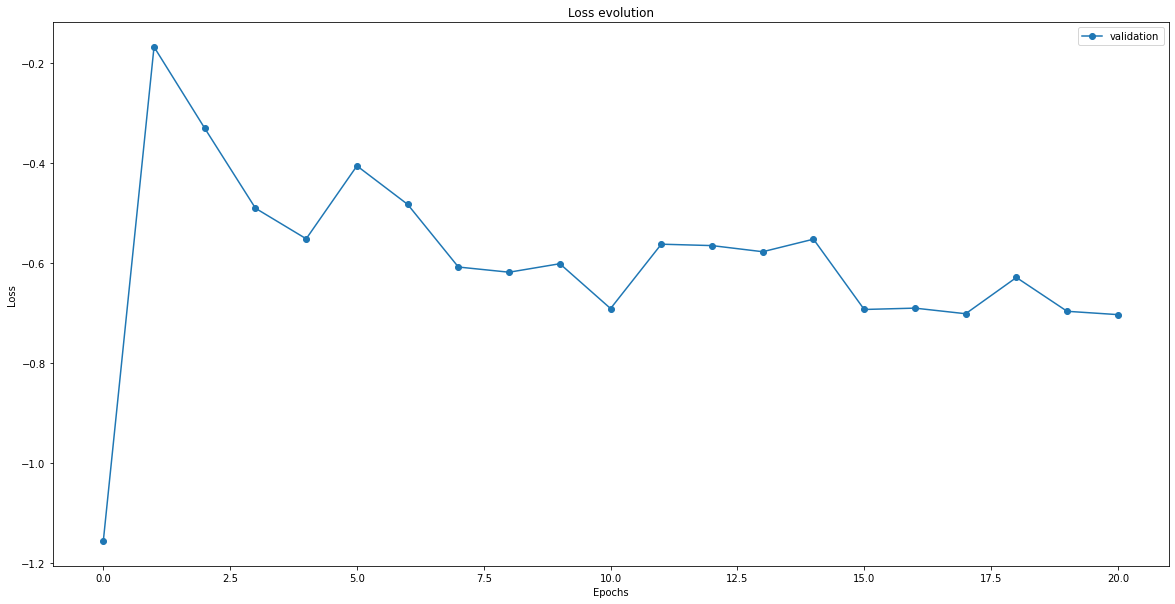

Random seed set as 42


  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Iter:  0
Train loss:  -1.106
Val loss:  -0.455
Validation Sharpe Ratio
C:  0 SR:  0.588
C:  1 SR:  0.545
C:  5 SR:  0.373
C:  10 SR:  0.159
Epochs till end:  9



  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Iter:  1
Train loss:  -2.861
Val loss:  -0.51
Validation Sharpe Ratio
C:  0 SR:  0.637
C:  1 SR:  0.594
C:  5 SR:  0.422
C:  10 SR:  0.209
Epochs till end:  10



  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Iter:  2
Train loss:  -4.713
Val loss:  -0.698
Validation Sharpe Ratio
C:  0 SR:  0.988
C:  1 SR:  0.94
C:  5 SR:  0.748
C:  10 SR:  0.509
Epochs till end:  10



  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Iter:  3
Train loss:  -5.962
Val loss:  -0.687
Validation Sharpe Ratio
C:  0 SR:  0.89
C:  1 SR:  0.837
C:  5 SR:  0.624
C:  10 SR:  0.359
Epochs till end:  9



  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Iter:  4
Train loss:  -6.992
Val loss:  -0.64
Validation Sharpe Ratio
C:  0 SR:  0.821
C:  1 SR:  0.755
C:  5 SR:  0.492
C:  10 SR:  0.164
Epochs till end:  8



  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Iter:  5
Train loss:  -7.68
Val loss:  -0.769
Validation Sharpe Ratio
C:  0 SR:  1.057
C:  1 SR:  0.988
C:  5 SR:  0.711
C:  10 SR:  0.366
Epochs till end:  10



  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Iter:  6
Train loss:  -8.223
Val loss:  -0.724
Validation Sharpe Ratio
C:  0 SR:  0.935
C:  1 SR:  0.859
C:  5 SR:  0.555
C:  10 SR:  0.176
Epochs till end:  9



  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Iter:  7
Train loss:  -8.624
Val loss:  -0.761
Validation Sharpe Ratio
C:  0 SR:  1.008
C:  1 SR:  0.928
C:  5 SR:  0.606
C:  10 SR:  0.204
Epochs till end:  8



  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Iter:  8
Train loss:  -9.12
Val loss:  -0.865
Validation Sharpe Ratio
C:  0 SR:  1.203
C:  1 SR:  1.111
C:  5 SR:  0.743
C:  10 SR:  0.284
Epochs till end:  10



  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Iter:  9
Train loss:  -9.425
Val loss:  -0.951
Validation Sharpe Ratio
C:  0 SR:  1.303
C:  1 SR:  1.202
C:  5 SR:  0.8
C:  10 SR:  0.298
Epochs till end:  10



  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Iter:  10
Train loss:  -9.851
Val loss:  -0.886
Validation Sharpe Ratio
C:  0 SR:  1.178
C:  1 SR:  1.072
C:  5 SR:  0.651
C:  10 SR:  0.125
Epochs till end:  9



  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Iter:  11
Train loss:  -10.125
Val loss:  -0.869
Validation Sharpe Ratio
C:  0 SR:  1.095
C:  1 SR:  0.99
C:  5 SR:  0.57
C:  10 SR:  0.046
Epochs till end:  8



  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Iter:  12
Train loss:  -10.371
Val loss:  -0.877
Validation Sharpe Ratio
C:  0 SR:  1.126
C:  1 SR:  1.016
C:  5 SR:  0.577
C:  10 SR:  0.03
Epochs till end:  7



  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

Iter:  13
Train loss:  -10.613
Val loss:  -0.855
Validation Sharpe Ratio
C:  0 SR:  1.034
C:  1 SR:  0.921
C:  5 SR:  0.473
C:  10 SR:  -0.087
Epochs till end:  6



  0%|          | 0/21 [00:00<?, ?it/s]

In [ ]:
for seed in [42]:
    
    if not os.path.exists('weights'):
        os.mkdir('weights')
    if not os.path.exists('results'):
        os.mkidr('results')
    
    test_dts = []
    results = {}
    splitter = MultivariateTrainValTestSplitter(features, cols_to_use, datetime_cols,
                                                'target_returns', 'target_returns_nonscaled',
                                                'daily_vol', scaling=scaling, timesteps=history_size,
                                                 encoder_length=encoder_length)
    for start in date_range:
        train_loader, val_loader, test_loader, test_dt, cat_info = splitter.split(start, val_delta,
                                                                                  test_delta, seed)
        test_dts.append(test_dt)
        if len(test_loader) == 0:
            continue
        
        dt = start
        results[dt] = {}
        
        batch_data = next(iter(train_loader))
        if model_type != 'tft':
            batch_x, batch_y, _, _ = batch_data
        else:
            batch_x, _, _, _, _, _, batch_y, _, _ = batch_data
        
        input_dim = batch_x.shape[2]
        output_dim = batch_y.shape[2]
        timesteps = history_size
        
        _set_seed(seed)
        model = MODEL_MAPPING[model_type](input_dim, output_dim,
                                          timesteps, cat_info=cat_info, **model_params).to(device)
        
        opt = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        sc = torch.optim.lr_scheduler.StepLR(opt, decay_steps, decay_gamma)

        counter = 0
        
        train_losses = []
        train_l1_losses = []
        train_turnover_losses = []
        val_losses = []
        val_turnover_losses = []
        best_val_sharpe = np.NINF
        
        for e in tqdm(range(n_epochs)):
            train_loss = 0
            train_l1_loss = 0
            train_turnover_loss = 0
            model.train()
            for batch_data in tqdm(train_loader):
                for i in range(len(batch_data)):
                    batch_data[i] = batch_data[i].to(device)
                
                if model_type != 'tft':
                    batch_x, batch_y, batch_y_orig, batch_vol = batch_data
                    input_data = [batch_x]
                else:
                    batch_x_enc_real, batch_x_enc_cat, batch_x_dec_real, batch_x_dec_cat, \
                    batch_enc_len, batch_dec_len, batch_y, batch_y_orig, batch_vol = batch_data
                    input_data = [batch_x_enc_real, batch_x_enc_cat, batch_x_dec_real, batch_x_dec_cat, \
                                  batch_enc_len, batch_dec_len]
                    

                opt.zero_grad()

                output = model(*input_data)

                l = sharpe_loss(output, batch_y)
                train_loss += l.item()
            
                if apply_l1_reg:
                    l_l1 = reg_l1(model)
                    train_l1_loss += l_l1.item()
                    l += l_l1

                if apply_turnover_reg:
                    l_turnover = reg_turnover(output, batch_vol)
                    train_turnover_loss += l_turnover.item()
                    l += l_turnover
                
                l.backward()
                opt.step()
            
            # we do not want learning rate to be too small
            if sc.get_last_lr()[0] > 1e-5:
                sc.step()
            
            val_loss = 0
            val_turnover_loss = 0
            
            preds = []
            returns = []
            vols = []
            
            model.eval()
            
            with torch.no_grad():
                for batch_data in tqdm(val_loader):
                    for i in range(len(batch_data)):
                        batch_data[i] = batch_data[i].to(device)

                    if model_type != 'tft':
                        batch_x, batch_y, batch_y_orig, batch_vol = batch_data
                        input_data = [batch_x]
                    else:
                        batch_x_enc_real, batch_x_enc_cat, batch_x_dec_real, batch_x_dec_cat, \
                        batch_enc_len, batch_dec_len, batch_y, batch_y_orig, batch_vol = batch_data
                        input_data = [batch_x_enc_real, batch_x_enc_cat, batch_x_dec_real, batch_x_dec_cat, \
                                      batch_enc_len, batch_dec_len]
                    
                    output = model(*input_data)
                    
                    l = sharpe_loss(output, batch_y)
                    val_loss += l.item()

                    if apply_turnover_reg:
                        l_turnover = reg_turnover(output, batch_vol)
                        val_turnover_loss += l_turnover.item()
                    
                    # select last timestep as we no longer need for time axis in batch
                    returns.append(batch_y[:, -1, :].detach().cpu().numpy())
                    preds.append(output[:, -1, :].detach().cpu().numpy())
                    vols.append(batch_vol[:, -1, :].detach().cpu().numpy())
                    
                    
            preds = np.concatenate(preds)
            returns = np.concatenate(returns)
            vols = np.concatenate(vols)
            
            #annualized volatility
            vols = vols * 252**0.5
            # validation turnover
            T = target_vol*np.abs(np.diff(preds/(vols+1e-12), prepend=0.0, axis=0))
            # validation sharpe ratios with different turnover strength
            val_sharpes = {}

            for c in basis_points:
                captured = returns*preds - 1e-4*c*T
                R = np.mean(captured, axis=1)
                sharpes = sharpe_ratio(R)
                #sharpes = [sharpe_ratio(captured[:, i]) for i in range(captured.shape[1])]
                sharpes = np.mean(sharpes)
                val_sharpes[c] = sharpes
                
            # one can use sharpe ratio averaged by all turnover coefficients as validation performance metric
            #val_sharpe = np.mean(list(val_sharpes.values()))
            
            val_sharpe = val_sharpes[0]
            
            if best_val_sharpe < val_sharpe and e > 0:
                best_val_sharpe = val_sharpe
                counter = 0
                torch.save(model.state_dict(), os.path.join('weights', '{}_seed_{}.pt'.format(model_type, seed)))
            
            else:
                counter += 1
            
            if counter > early_stopping_rounds:
                break
            
            train_loss /= len(train_loader)
            train_l1_loss/= len(train_loader)
            train_turnover_loss /= len(train_loader)
            val_loss /= len(val_loader)
            val_turnover_loss /= len(val_loader)
            
            train_losses.append(train_loss)
            train_l1_losses.append(train_l1_loss)
            train_turnover_losses.append(train_turnover_loss)
            val_losses.append(val_loss)
            val_turnover_losses.append(val_turnover_loss)
            
            print('Iter: ', e)
            print('Train loss: ', round(train_losses[-1], 3))
            print('Val loss: ', round(val_losses[-1], 3))
            print('Validation Sharpe Ratio')
            for key in val_sharpes.keys():
                print('C: ', key, 'SR: ', round(val_sharpes[key], 3))
            if apply_l1_reg:
                print('L1 loss', round(train_l1_losses[-1], 5))
            if apply_turnover_reg:
                print('Train turnover loss: ', round(train_turnover_losses[-1], 5))
                print('Val turnover loss: ', round(val_turnover_losses[-1], 5))
            print('Epochs till end: ', early_stopping_rounds - counter)
            print()
        
        print('Validation dates: ', start, start+val_delta)
        
        plt.figure(figsize=(20, 10))
        plt.title('Loss evolution')
        #plt.plot(train_losses, label='train', marker='o')
        plt.plot(val_losses, label='validation', marker='o')
        plt.ylabel('Loss')
        plt.xlabel('Epochs')
        plt.legend()
        plt.show()
        
        if apply_l1_reg:
            plt.figure(figsize=(20, 10))
            plt.title('L1 regularization loss evolution')
            plt.plot(train_l1_losses, label='train', marker='o')
            plt.ylabel('L1 Loss')
            plt.xlabel('Epochs')
            plt.legend()
            plt.show()
        
        if apply_turnover_reg:
            plt.figure(figsize=(20, 10))
            plt.title('Turnover loss evolution')
            plt.plot(train_turnover_losses, label='train', marker='o')
            plt.plot(val_turnover_losses, label='validation', marker='o')
            plt.ylabel('Turnover loss')
            plt.xlabel('Epochs')
            plt.legend()
            plt.show()
        
        model.load_state_dict(torch.load(os.path.join('weights', '{}_seed_{}.pt'.format(model_type, seed))))
        model = model.to(device)
        model.eval()
        
        val_preds = []
        val_returns = []
        val_returns_orig = []
        val_vols = []

        model.eval()

        with torch.no_grad():
            for batch_data in val_loader:
                for i in range(len(batch_data)):
                    batch_data[i] = batch_data[i].to(device)
                
                if model_type != 'tft':
                    batch_x, batch_y, batch_y_orig, batch_vol = batch_data
                    input_data = [batch_x]
                else:
                    batch_x_enc_real, batch_x_enc_cat, batch_x_dec_real, batch_x_dec_cat, \
                    batch_enc_len, batch_dec_len, batch_y, batch_y_orig, batch_vol = batch_data
                    input_data = [batch_x_enc_real, batch_x_enc_cat, batch_x_dec_real, batch_x_dec_cat, \
                                  batch_enc_len, batch_dec_len]

                output = model(*input_data)


                # select last timestep as we no longer need for time axis in batch
                val_returns.append(batch_y[:, -1, :].detach().cpu().numpy())
                val_returns_orig.append(batch_y_orig[:, -1, :].detach().cpu().numpy())
                val_preds.append(output[:, -1, :].detach().cpu().numpy())
                val_vols.append(batch_vol[:, -1, :].detach().cpu().numpy())


        val_preds = np.concatenate(val_preds)
        val_returns = np.concatenate(val_returns)
        val_returns_orig = np.concatenate(val_returns_orig)
        val_vols = np.concatenate(val_vols)
        
        test_preds = []
        test_returns = []
        test_returns_orig = []
        test_vols = []

        with torch.no_grad():
            for batch_data in test_loader:
                for i in range(len(batch_data)):
                    batch_data[i] = batch_data[i].to(device)
                
                if model_type != 'tft':
                    batch_x, batch_y, batch_y_orig, batch_vol = batch_data
                    input_data = [batch_x]
                else:
                    batch_x_enc_real, batch_x_enc_cat, batch_x_dec_real, batch_x_dec_cat, \
                    batch_enc_len, batch_dec_len, batch_y, batch_y_orig, batch_vol = batch_data
                    input_data = [batch_x_enc_real, batch_x_enc_cat, batch_x_dec_real, batch_x_dec_cat, \
                                  batch_enc_len, batch_dec_len]

                output = model(*input_data)


                # select last timestep as we no longer need for time axis in batch
                test_returns.append(batch_y[:, -1, :].detach().cpu().numpy())
                test_returns_orig.append(batch_y_orig[:, -1, :].detach().cpu().numpy())
                test_preds.append(output[:, -1, :].detach().cpu().numpy())
                test_vols.append(batch_vol[:, -1, :].detach().cpu().numpy())


        test_preds = np.concatenate(test_preds)
        test_returns = np.concatenate(test_returns)
        test_returns_orig = np.concatenate(test_returns_orig)
        test_vols = np.concatenate(test_vols)

        results[dt]['val'] = {}
        results[dt]['test'] = {}
        results[dt]['test_dt'] = test_dt
        
        results[dt]['val']['preds'] = val_preds
        results[dt]['val']['returns'] = val_returns
        results[dt]['val']['returns_orig'] = val_returns_orig
        results[dt]['val']['vols'] = val_vols
        
        results[dt]['test']['preds'] = test_preds
        results[dt]['test']['returns'] = test_returns
        results[dt]['test']['returns_orig'] = test_returns_orig
        results[dt]['test']['vols'] = test_vols
        
        
    with open(os.path.join('results', '{}_seed_{}_2.pickle'.format(model_type, seed)), 'wb') as f:
        pickle.dump(results, f)

In [ ]:
cat_info

In [ ]:
for i in range(3):
    print(batch_x_enc_cat[:, :, i].max(), batch_x_dec_cat[:, :, i].max())

In [ ]:
len(batch_data)

In [ ]:
batch_x.shape

In [ ]:
440*0.3

In [ ]:
T.shape

In [ ]:
captured.shape

In [ ]:
CHECK TURNOVER CALCULATION IN PAPER CODE

In [20]:
with open(os.path.join('results', '{}_seed_{}.pickle'.format(model_type, seed)), 'rb') as f:
    s = pickle.load(f)

In [21]:
s.keys()

dict_keys([Timestamp('2017-01-01 00:00:00', freq='365D'), Timestamp('2018-01-01 00:00:00', freq='365D'), Timestamp('2019-01-01 00:00:00', freq='365D'), Timestamp('2020-01-01 00:00:00', freq='365D'), Timestamp('2020-12-31 00:00:00', freq='365D'), Timestamp('2021-12-31 00:00:00', freq='365D')])

In [22]:
s

{Timestamp('2017-01-01 00:00:00', freq='365D'): {'val': {'preds': array([[-0.06719825, -0.12165906, -0.15836045, ..., -0.02192476,
           -0.05855001, -0.04660154],
          [-0.05941394, -0.09929574, -0.16683619, ..., -0.0629783 ,
           -0.06911193, -0.05740706],
          [-0.03437181, -0.10851533, -0.13773099, ..., -0.0302827 ,
           -0.07600641, -0.05329055],
          ...,
          [-0.06244482, -0.08418113,  0.01842139, ..., -0.07675992,
           -0.1257724 ,  0.00476152],
          [-0.06811493, -0.07323923,  0.00766079, ..., -0.12835382,
           -0.1904522 , -0.03424367],
          [-0.02420451, -0.09484015,  0.01929842, ..., -0.08453773,
           -0.18312718, -0.03283702]], dtype=float32),
   'returns': array([[ 0.01218061, -0.0002563 ,  0.00401444, ...,  0.00114788,
            0.00839684,  0.00594892],
          [ 0.00948089,  0.00570152, -0.01789113, ...,  0.00440326,
            0.        , -0.00164429],
          [-0.0004819 ,  0.01330482,  0.017872

In [24]:
batch_y[0]

tensor([[ 2.5797e-03,  3.7085e-04, -3.2144e-03,  ..., -8.8253e-03,
         -5.5738e-03, -7.6499e-03],
        [-4.4201e-03,  5.9013e-03,  3.8420e-03,  ...,  8.9822e-05,
          5.0745e-03, -2.9620e-03],
        [ 6.8760e-03,  7.9661e-04,  4.4505e-03,  ..., -5.1095e-03,
          2.1016e-03, -3.1893e-03],
        ...,
        [-2.2367e-03, -2.9538e-03, -1.8163e-03,  ..., -9.4694e-03,
          5.8776e-04, -4.8728e-04],
        [ 2.2782e-03, -1.4484e-02,  3.1967e-03,  ...,  4.6133e-04,
         -5.9723e-04,  1.9829e-03],
        [ 7.0853e-02,  3.3031e-03,  1.2235e-02,  ...,  1.5749e-02,
          1.2759e-02,  1.5639e-02]])

In [25]:
batch_y_orig[0]

tensor([[ 0.0045,  0.0007, -0.0058,  ..., -0.0118, -0.0065, -0.0093],
        [-0.0076,  0.0115,  0.0068,  ...,  0.0001,  0.0059, -0.0036],
        [ 0.0117,  0.0015,  0.0078,  ..., -0.0067,  0.0024, -0.0038],
        ...,
        [-0.0033, -0.0052, -0.0029,  ..., -0.0122,  0.0007, -0.0006],
        [ 0.0033, -0.0254,  0.0050,  ...,  0.0006, -0.0007,  0.0022],
        [ 0.1002,  0.0059,  0.0189,  ...,  0.0199,  0.0143,  0.0172]])

In [18]:
results['test']['preds'] = test_preds
results['test']['returns'] = test_returns
results['test']['returns_orig'] = test_returns_orig
results['test']['vols'] = test_vols

In [41]:
T

array([[0.83383634, 0.51192949, 0.28745112, ..., 0.18885391, 1.07419992,
        1.04470401],
       [0.67396717, 0.55053077, 0.53674765, ..., 0.62509811, 0.56359869,
        0.24428089],
       [0.32709056, 0.61189209, 0.3497896 , ..., 0.01410749, 0.66190774,
        0.9456643 ],
       ...,
       [0.87709293, 0.57821921, 0.4666867 , ..., 0.39466517, 0.78080213,
        0.70181444],
       [0.03822577, 0.38370012, 0.83944019, ..., 0.0178256 , 0.54594523,
        0.74240624],
       [0.57244881, 0.2677478 , 0.34134158, ..., 0.32640767, 0.57954612,
        0.71406727]])

In [36]:
batch_x, batch_y, batch_y_orig, batch_vol = next(iter(train_loader))

In [37]:
batch_x.shape, batch_vol.shape

(torch.Size([64, 21, 440]), torch.Size([64, 21, 55]))

In [38]:
batch_x.max()

tensor(5.8374)

In [39]:
batch_x.min()

tensor(-5.7343)

In [40]:
batch_y.shape, batch_y_orig.shape

(torch.Size([64, 21, 55]), torch.Size([64, 21, 55]))

In [69]:
#model = LSTMnet(batch_x.shape[2], batch_y.shape[2], batch_x.shape[1])
#model = SLP(batch_x.shape[2], batch_y.shape[2], batch_x.shape[1])
#model = MLP(batch_x.shape[2], batch_y.shape[2], batch_x.shape[1])
model = TCN(batch_x.shape[2], batch_y.shape[2], batch_x.shape[1], 5)

In [ ]:
val_preds = []
val_returns = []
val_returns_orig = []
val_vols = []

model.eval()

with torch.no_grad():
    for batch_x, batch_y, batch_y_orig, batch_vol in val_loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        batch_y_orig = batch_y_orig.to(device)
        batch_vol = batch_vol.to(device)

        output = model(batch_x)


        # select last timestep as we no longer need for time axis in batch
        val_returns.append(batch_y[:, -1, :].detach().cpu().numpy())
        val_returns_orig.append(batch_y[:, -1, :].detach().cpu().numpy())
        val_preds.append(output[:, -1, :].detach().cpu().numpy())
        val_vols.append(batch_vol[:, -1, :].detach().cpu().numpy())


val_preds = np.concatenate(val_preds)
val_returns = np.concatenate(val_returns)
val_returns_orig = np.concatenate(val_returns_orig)
val_vols = np.concatenate(val_vols)

In [ ]:
test_preds = []
test_returns = []
test_returns_orig = []
test_vols = []

with torch.no_grad():
    for batch_x, batch_y, batch_y_orig, batch_vol in test_loader:
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        batch_y_orig = batch_y_orig.to(device)
        batch_vol = batch_vol.to(device)

        output = model(batch_x)


        # select last timestep as we no longer need for time axis in batch
        test_returns.append(batch_y[:, -1, :].detach().cpu().numpy())
        test_returns_orig.append(batch_y[:, -1, :].detach().cpu().numpy())
        test_preds.append(output[:, -1, :].detach().cpu().numpy())
        test_vols.append(batch_vol[:, -1, :].detach().cpu().numpy())


test_preds = np.concatenate(test_preds)
test_returns = np.concatenate(test_returns)
test_returns_orig = np.concatenate(test_returns_orig)
test_vols = np.concatenate(test_vols)

